In [227]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from scipy.stats import kurtosis
from scipy.stats import skew
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import auc, accuracy_score, f1_score, precision_recall_curve, classification_report, average_precision_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, log_loss, cohen_kappa_score, roc_auc_score, roc_curve
 


%matplotlib inline

In [163]:
loan = pd.read_csv(os.path.abspath(os.path.join(os.getcwd(), 'data\\train_loanpred.csv')))
loan.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0,141.0,360.0,1.0,Urban,Y


In [164]:
loan.shape

(614, 13)

In [165]:
loan.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome      int64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [166]:
missing_val = loan.isna().sum().sort_values(ascending=False)
missing_val

Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Loan_ID               0
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
dtype: int64

In [167]:
missing_pct = round(missing_val[missing_val > 0]/loan.shape[0]  * 100, 2)
missing_pct.apply(lambda x: f'{str(x)}%')

Credit_History      8.14%
Self_Employed       5.21%
LoanAmount          3.58%
Dependents          2.44%
Loan_Amount_Term    2.28%
Gender              2.12%
Married             0.49%
dtype: object

In [168]:
#print rows with Nan
loan[loan.isnull().any(axis=1)]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0,NaN,360.0,1.0,Urban,Y
11,LP001027,Male,Yes,2,Graduate,NaN,2500,1840,109.0,360.0,1.0,Urban,Y
16,LP001034,Male,No,1,Not Graduate,No,3596,0,100.0,240.0,NaN,Urban,Y
19,LP001041,Male,Yes,0,Graduate,NaN,2600,3500,115.0,NaN,1.0,Urban,Y
23,LP001050,NaN,Yes,2,Not Graduate,No,3365,1917,112.0,360.0,0.0,Rural,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,LP002933,NaN,No,3+,Graduate,Yes,9357,0,292.0,360.0,1.0,Semiurban,Y
597,LP002943,Male,No,NaN,Graduate,No,2987,0,88.0,360.0,0.0,Semiurban,N
600,LP002949,Female,No,3+,Graduate,NaN,416,41667,350.0,180.0,NaN,Urban,N
601,LP002950,Male,Yes,0,Not Graduate,NaN,2894,2792,155.0,360.0,1.0,Rural,Y


## Numeric variable analysis

In [169]:
loan.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.244300,2926.248760,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


<Axes: xlabel='LoanAmount', ylabel='Count'>

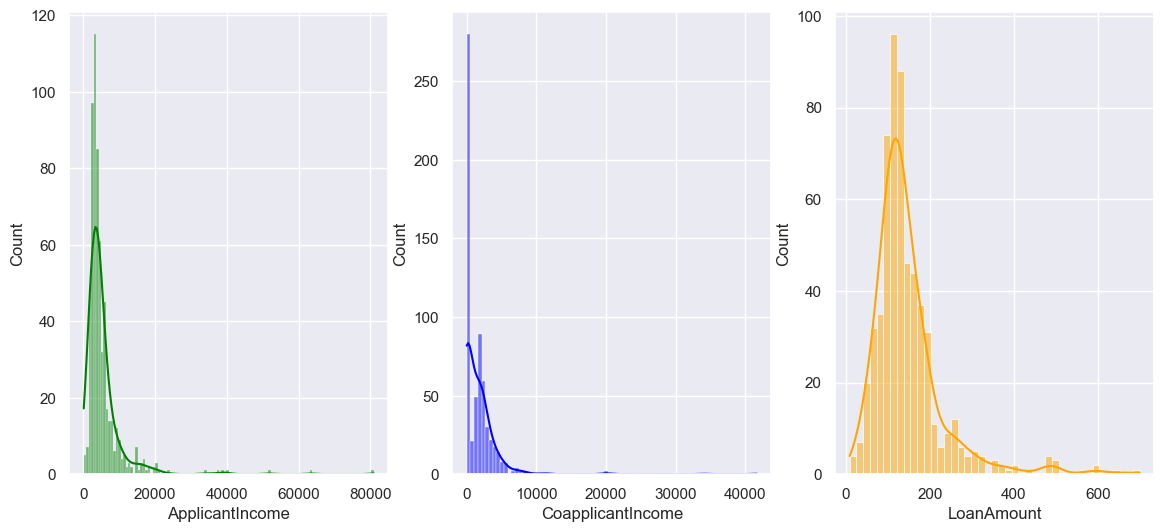

In [170]:
sns.set(style="darkgrid")
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

sns.histplot(data=loan, x="ApplicantIncome", kde=True, ax=ax[0], color='green')
sns.histplot(data=loan, x="CoapplicantIncome", kde=True, ax=ax[1], color='blue')
sns.histplot(data=loan, x="LoanAmount", kde=True, ax=ax[2], color='orange')

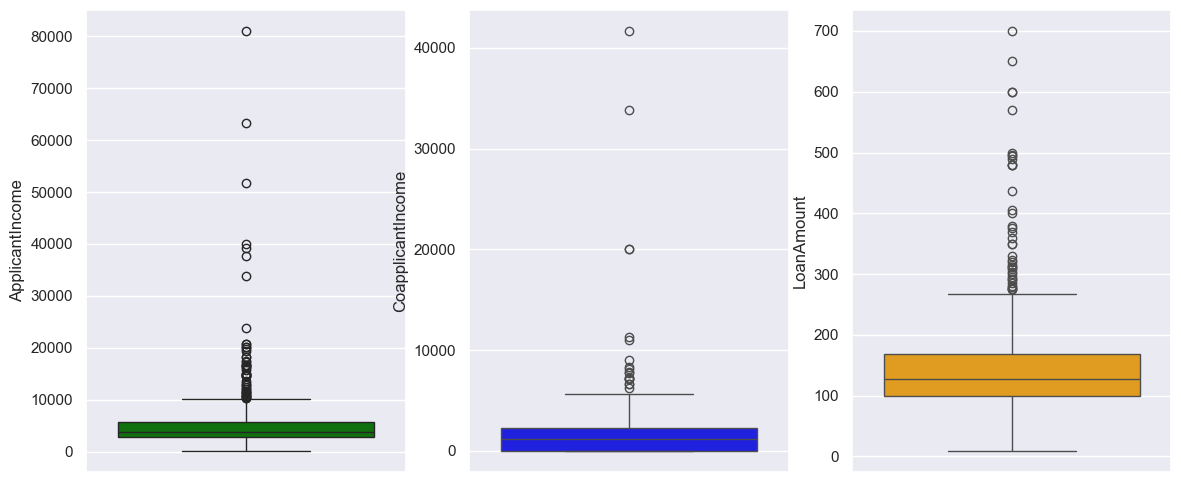

In [171]:
#Check for outliers in numeric variables
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

sns.boxplot(data=loan, y="ApplicantIncome", ax=ax[0], color='green')
sns.boxplot(data=loan, y="CoapplicantIncome", ax=ax[1], color='blue')
sns.boxplot(data=loan, y="LoanAmount", ax=ax[2], color='orange');

In [172]:
def iqr(df:pd.DataFrame, column:str):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

def analyze_numerical(df, numeric_cols):
    data = []
    for col in numeric_cols:
        outliers = iqr(df, col) 
        data.append({"column": col, 
                 "missing": df[col].isna().sum(), 
                 "outliers": len(outliers), 
                 "skew": skew(df[col])
                })
    num_df = pd.DataFrame(data)
    return num_df

In [173]:
numeric_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
analyze_numerical(loan, numeric_cols)

,column,missing,outliers,skew
0,ApplicantIncome,0,50,6.523526
1,CoapplicantIncome,0,18,7.473215
2,LoanAmount,22,39,NaN


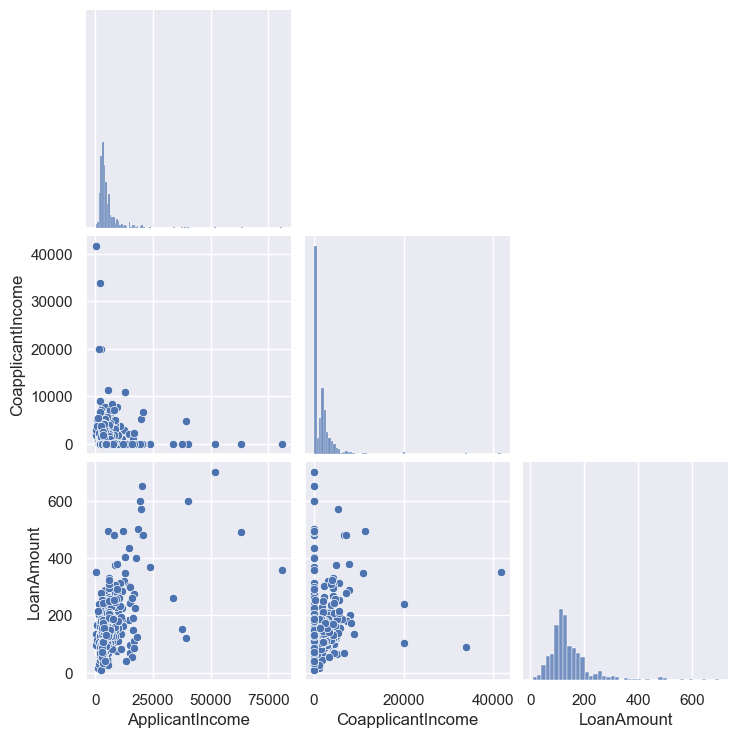

In [174]:
#numeric vs numeric relationship
sns.pairplot(loan[numeric_cols], corner=True)

In [175]:
#numerical outliers vs target
applicant_outliers = iqr(loan, numeric_cols[0])
loan_outliers = loan.copy()
loan_outliers["ApplicantIncome_Flag"] = np.where(loan_outliers.index.isin(applicant_outliers.index), 1, 0)
pd.crosstab(loan_outliers['ApplicantIncome_Flag'], loan_outliers["Loan_Status"], normalize='index')

Loan_Status,N,Y
ApplicantIncome_Flag,,
0,0.310284,0.689716
1,0.340000,0.660000


Text(0.5, 1.0, 'Distribution of Target Variable by Outlier Status')

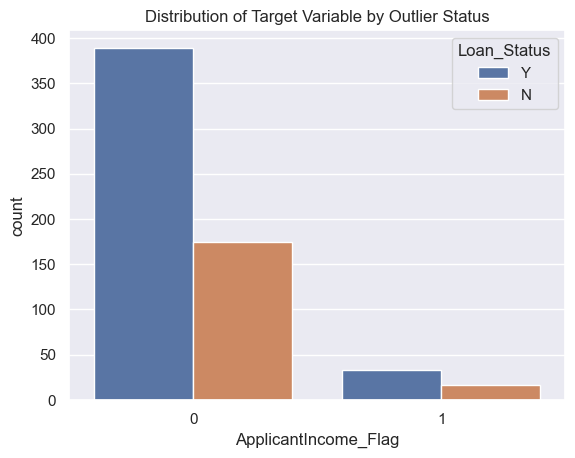

In [176]:
sns.countplot(x=loan_outliers['ApplicantIncome_Flag'], hue=loan_outliers["Loan_Status"])
plt.title("Distribution of Target Variable by Outlier Status")

In [177]:
contingency_table = pd.crosstab(loan_outliers['ApplicantIncome_Flag'], loan_outliers["Loan_Status"])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}, P-value: {p}")
#If p < 0.05, outliers significantly impact the target distribution. Here, no impact so we can transform the outliers

Chi-Square Statistic: 0.07576953558283761, P-value: 0.7831144447291886


In [178]:
co_applicant_outliers = iqr(loan, numeric_cols[1])
loan_outliers_coapp = loan.copy()
loan_outliers_coapp["CoApplicantIncome_Flag"] = np.where(loan_outliers_coapp.index.isin(co_applicant_outliers.index), 1, 0)
pd.crosstab(loan_outliers_coapp['CoApplicantIncome_Flag'], loan_outliers_coapp["Loan_Status"], normalize='index')

Loan_Status,N,Y
CoApplicantIncome_Flag,,
0,0.308725,0.691275
1,0.444444,0.555556


In [179]:
contingency_table = pd.crosstab(loan_outliers_coapp['CoApplicantIncome_Flag'], loan_outliers_coapp["Loan_Status"])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}, P-value: {p}")

Chi-Square Statistic: 0.9325582833357189, P-value: 0.33419903791904465


In [180]:
loan_amt_outliers = iqr(loan, numeric_cols[2])
loan_outliers_amt = loan.copy()
loan_outliers_amt["LoanAmount_Flag"] = np.where(loan_outliers_amt.index.isin(loan_amt_outliers.index), 1, 0)
pd.crosstab(loan_outliers_amt['LoanAmount_Flag'], loan_outliers_amt["Loan_Status"], normalize='index')

Loan_Status,N,Y
LoanAmount_Flag,,
0,0.307826,0.692174
1,0.384615,0.615385


In [181]:
contingency_table = pd.crosstab(loan_outliers_amt['LoanAmount_Flag'], loan_outliers_amt["Loan_Status"])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}, P-value: {p}")

Chi-Square Statistic: 0.6766048701481684, P-value: 0.4107582821654169


In [182]:
numeric_pipeline = Pipeline(steps=[
    ("impute", SimpleImputer(missing_values=np.nan, strategy='median')),
    ("log1p", FunctionTransformer(np.log1p, validate=True))

])

numeric_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('log1p',
                 FunctionTransformer(func=<ufunc 'log1p'>, validate=True))])

In [183]:
numeric_transforms = ColumnTransformer(transformers=[
    ("numeric_pipeline", numeric_pipeline, numeric_cols),
], remainder='passthrough')


In [184]:
numeric_transformed_loan = numeric_transforms.fit_transform(loan)
numeric_transformed_loan_df = pd.DataFrame(numeric_transformed_loan, columns=loan.columns, index=loan.index)
numeric_transformed_loan_df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,8.674197,0.0,4.859812,LP001002,Male,No,0,Graduate,No,360.0,1.0,Urban,Y
1,8.430327,7.319202,4.859812,LP001003,Male,Yes,1,Graduate,No,360.0,1.0,Rural,N
2,8.006701,0.0,4.204693,LP001005,Male,Yes,0,Graduate,Yes,360.0,1.0,Urban,Y
3,7.857094,7.765993,4.795791,LP001006,Male,Yes,0,Not Graduate,No,360.0,1.0,Urban,Y
4,8.699681,0.0,4.955827,LP001008,Male,No,0,Graduate,No,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,7.972811,0.0,4.276666,LP002978,Female,No,0,Graduate,No,360.0,1.0,Rural,Y
610,8.320448,0.0,3.713572,LP002979,Male,Yes,3+,Graduate,No,180.0,1.0,Rural,Y
611,8.99628,5.484797,5.537334,LP002983,Male,Yes,1,Graduate,No,360.0,1.0,Urban,Y
612,8.933796,0.0,5.236442,LP002984,Male,Yes,2,Graduate,No,360.0,1.0,Urban,Y


In [185]:
numeric_transformed = numeric_pipeline.fit_transform(loan[numeric_cols])
numeric_transformed_df = pd.DataFrame(numeric_transformed, columns=numeric_cols, index=loan.index)
numeric_transformed_df

,ApplicantIncome,CoapplicantIncome,LoanAmount
0,8.674197,0.000000,4.859812
1,8.430327,7.319202,4.859812
2,8.006701,0.000000,4.204693
3,7.857094,7.765993,4.795791
4,8.699681,0.000000,4.955827
...,...,...,...
609,7.972811,0.000000,4.276666
610,8.320448,0.000000,3.713572
611,8.996280,5.484797,5.537334
612,8.933796,0.000000,5.236442


In [186]:
#after EDA
analyze_numerical(numeric_transformed_df, numeric_cols)

,column,missing,outliers,skew
0,ApplicantIncome,0,27,0.480949
1,CoapplicantIncome,0,0,-0.172642
2,LoanAmount,0,39,-0.151207


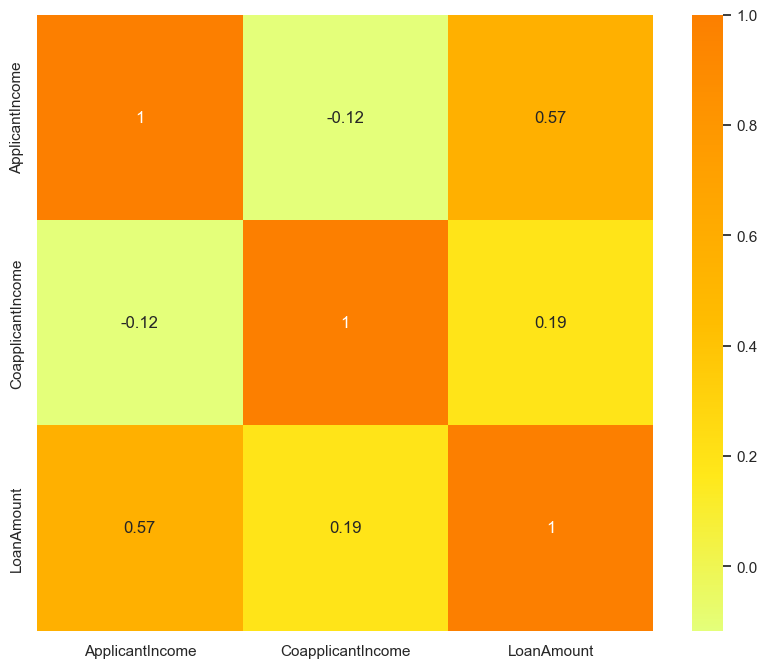

In [187]:
#numerical vs numerical 
corr = loan[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr ,cmap = 'Wistia', annot=True, square=True)
plt.show()

## Categorical variable analysis

In [188]:
#drop unwanted column
loan.drop(columns=['Loan_ID'], axis=1, inplace=True)

In [189]:
#convert Loan_Amount_Term to category
loan["Loan_Amount_Term"] = loan["Loan_Amount_Term"].astype('category')

In [190]:
cat = loan.select_dtypes(include=['object', 'category']).columns
cat_cols = cat.drop("Loan_Status").values
cat_cols

array(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Loan_Amount_Term', 'Property_Area'], dtype=object)

In [191]:
print(loan['Gender'].value_counts())  # Absolute counts
print(loan['Gender'].value_counts(normalize=True))  # Relative frequencies (%)

Gender
Male      489
Female    112
Name: count, dtype: int64
Gender
Male      0.813644
Female    0.186356
Name: proportion, dtype: float64


<Axes: xlabel='percent', ylabel='Property_Area'>

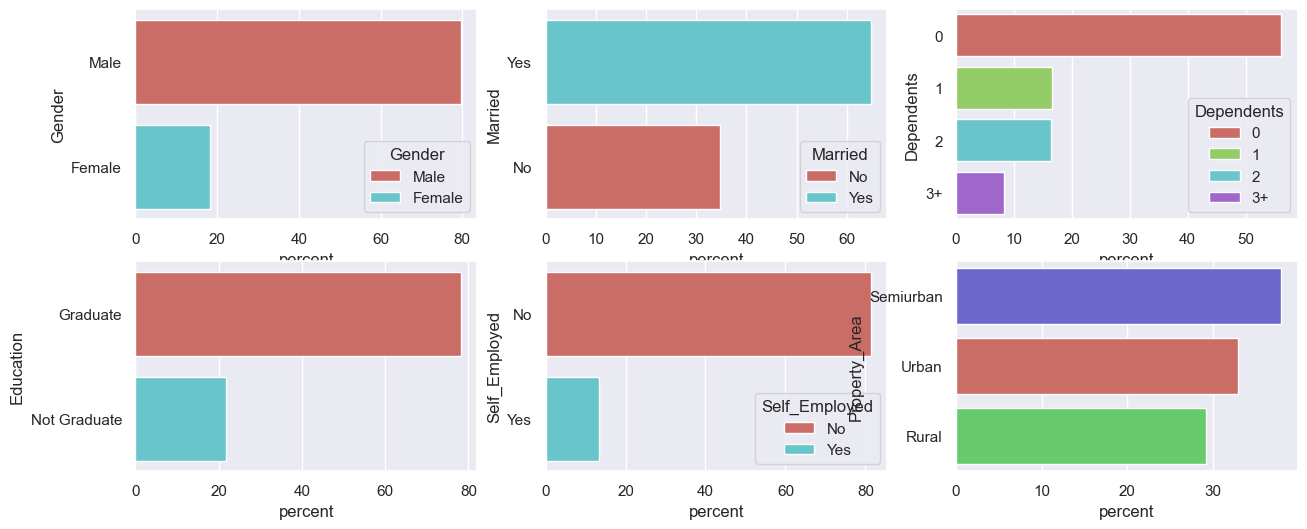

In [192]:
#check categorical distribution and outliers
fig, ax = plt.subplots(2,3, figsize=(15, 6))
sns.countplot(y=loan['Gender'], order=loan['Gender'].value_counts().index, hue=loan['Gender'], stat='percent', palette='hls', ax=ax[0,0])
sns.countplot(y=loan['Married'], order=loan['Married'].value_counts().index, hue=loan['Married'], stat='percent', palette='hls', ax=ax[0,1]) 
sns.countplot(y=loan['Dependents'], order=loan['Dependents'].value_counts().index, hue=loan['Dependents'], stat='percent', palette='hls', ax=ax[0,2]) 
sns.countplot(y=loan['Education'], order=loan['Education'].value_counts().index, hue=loan['Education'], stat='percent', palette='hls', ax=ax[1,0]) 
sns.countplot(y=loan['Self_Employed'], order=loan['Self_Employed'].value_counts().index, hue=loan['Self_Employed'], palette='hls', stat='percent', ax=ax[1,1]) 
sns.countplot(y=loan['Property_Area'], order=loan['Property_Area'].value_counts().index, hue=loan['Property_Area'], palette='hls', stat='percent', ax=ax[1,2]) 


<Axes: xlabel='Loan_Amount_Term', ylabel='count'>

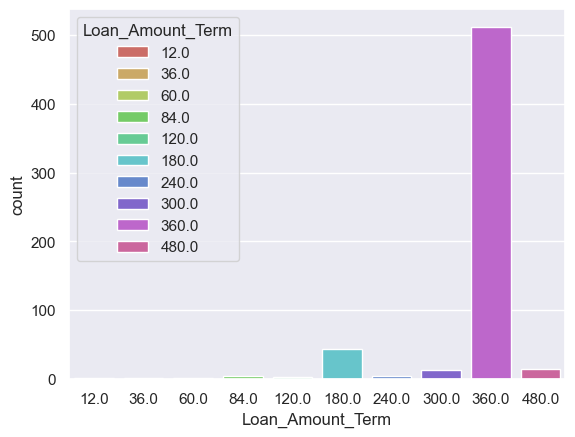

In [193]:
#discrete value analysis
sns.countplot(x=loan["Loan_Amount_Term"], hue= loan["Loan_Amount_Term"],  palette='hls')

In [194]:
#cat vs cat relationship analysis - chi squared
from itertools import product

cat_var_prod = list(product(cat_cols,cat_cols, repeat = 1))

df_cat = loan[cat_cols]
result = []
for i in cat_var_prod:
    if i[0] != i[1]:
        result.append((i[0],i[1],list(chi2_contingency(pd.crosstab(df_cat[i[0]], df_cat[i[1]])))[1]))

chi_test_output = pd.DataFrame(result, columns = ['var1', 'var2', 'p-val'])
chi_test_output.pivot(index='var1', columns='var2', values='p-val')

var2,Dependents,Education,Gender,Loan_Amount_Term,Married,Property_Area,Self_Employed
var1,,,,,,,
Dependents,NaN,0.472473,2.409881e-04,0.135798,1.178581e-17,0.314098,0.104556
Education,4.724732e-01,NaN,2.795190e-01,0.304680,8.033654e-01,0.158031,0.877840
Gender,2.409881e-04,0.279519,NaN,0.482415,4.324706e-19,0.018023,0.938809
Loan_Amount_Term,1.357982e-01,0.304680,4.824146e-01,NaN,3.129547e-02,0.118147,0.739756
Married,1.178581e-17,0.803365,4.324706e-19,0.031295,NaN,0.992893,1.000000
Property_Area,3.140983e-01,0.158031,1.802317e-02,0.118147,9.928935e-01,NaN,0.748146
Self_Employed,1.045560e-01,0.877840,9.388089e-01,0.739756,1.000000e+00,0.748146,NaN


In [195]:
#check correlation between cat variables - cramer's_v
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

for i in cat_var_prod:
    if i[0] != i[1]:
        print(f'{i} - {cramers_v(loan[i[0]], loan[i[1]])}')

('Gender', 'Married') - 0.365106746038068
('Gender', 'Dependents') - 0.18131561789217351
('Gender', 'Education') - 0.04411125015758613
('Gender', 'Self_Employed') - 0.0032182411222942305
('Gender', 'Loan_Amount_Term') - 0.12049738922777065
('Gender', 'Property_Area') - 0.11560586155657229
('Married', 'Gender') - 0.365106746038068
('Married', 'Dependents') - 0.36985225381386394
('Married', 'Education') - 0.010073217908373032
('Married', 'Self_Employed') - 0.0
('Married', 'Loan_Amount_Term') - 0.175332541618809
('Married', 'Property_Area') - 0.004831662947224027
('Dependents', 'Gender') - 0.1813156178921735
('Dependents', 'Married') - 0.369852253813864
('Dependents', 'Education') - 0.06480520720348182
('Dependents', 'Self_Employed') - 0.1041431434788516
('Dependents', 'Loan_Amount_Term') - 0.14134524658061612
('Dependents', 'Property_Area') - 0.07684055876005112
('Education', 'Gender') - 0.04411125015758613
('Education', 'Married') - 0.010073217908373034
('Education', 'Dependents') - 0.0

In [196]:
from sklearn.base import BaseEstimator, TransformerMixin


class SimpleImputerWithMapping(BaseEstimator, TransformerMixin):
    def __init__(self, mapping, target_col, reference_col):
        self.mapping = mapping  
        self.target_col = target_col 
        self.reference_col = reference_col
    
    def fit(self, X, y=None):
        return self  # No training needed, just a transformation
    
    def transform(self, X):
        X = X.copy() 
        missing_idx = X[X[self.target_col].isnull()].index 
        X.loc[missing_idx, self.target_col] = X.loc[missing_idx, self.reference_col].map(self.mapping)
        return X



class CustomBinning(BaseEstimator, TransformerMixin):
    def __init__(self, target_col):
        self.target_col = target_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X_new = pd.cut(X[self.target_col], bins=[0, 150, 300, 500], labels=['Short', 'Medium', 'Long'])
        #X = pd.concat([X.drop(self.target_col, axis=1), X_new], axis=1)
        X[self.target_col] = X_new
        return X


class DataFrameConverter(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.DataFrame(X, columns=self.feature_names)


In [197]:
mapping = {"Graduate":"No", "Not Graduate": "Yes" }

cat_pipeline = Pipeline(steps=[
    ("custom_imputer", SimpleImputerWithMapping(mapping, target_col="Self_Employed", reference_col="Education")),
    ("custom_binning", CustomBinning(target_col="Loan_Amount_Term")),
    ("mode_impute", SimpleImputer(missing_values=np.nan, strategy='most_frequent')) ,
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False))

])


cat_transforms = ColumnTransformer(transformers=[
    ("cat_pipeline", cat_pipeline, cat_cols)
], remainder='passthrough')


cat_pipeline

Pipeline(steps=[('custom_imputer',
                 SimpleImputerWithMapping(mapping={'Graduate': 'No',
                                                   'Not Graduate': 'Yes'},
                                          reference_col='Education',
                                          target_col='Self_Employed')),
                ('custom_binning',
                 CustomBinning(target_col='Loan_Amount_Term')),
                ('mode_impute', SimpleImputer(strategy='most_frequent')),
                ('onehot',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))])

In [198]:
cat_transformed = cat_pipeline.fit_transform(loan[cat_cols])
cat_transformed_columns = cat_pipeline.named_steps["onehot"].get_feature_names_out(input_features=cat_cols)
cat_transformed_df = pd.DataFrame(
    cat_transformed, 
    columns=cat_transformed_columns,
    index=loan.index)

cat_transformed_df

,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Loan_Amount_Term_Medium,Loan_Amount_Term_Short,Property_Area_Semiurban,Property_Area_Urban
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
610,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
611,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
612,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [199]:
#impute binary column
bin_cols = ["Credit_History"]

binary_pipeline = Pipeline(steps=[
    ("binary_impute", SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    #("toDF", DataFrameConverter(loan_df.columns))
])

binary_impute = ColumnTransformer(transformers=[
    ("binary_pipeline", binary_pipeline , bin_cols)
])


binary_impute

ColumnTransformer(transformers=[('binary_pipeline',
                                 Pipeline(steps=[('binary_impute',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['Credit_History'])])

In [200]:
binary_transform = binary_impute.fit_transform(loan)
binary_transform_df = pd.DataFrame(binary_transform, columns=binary_impute.get_feature_names_out())
binary_transform_df

,binary_pipeline__Credit_History
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
609,1.0
610,1.0
611,1.0
612,1.0


# Target variable analysis

<Axes: xlabel='Property_Area'>

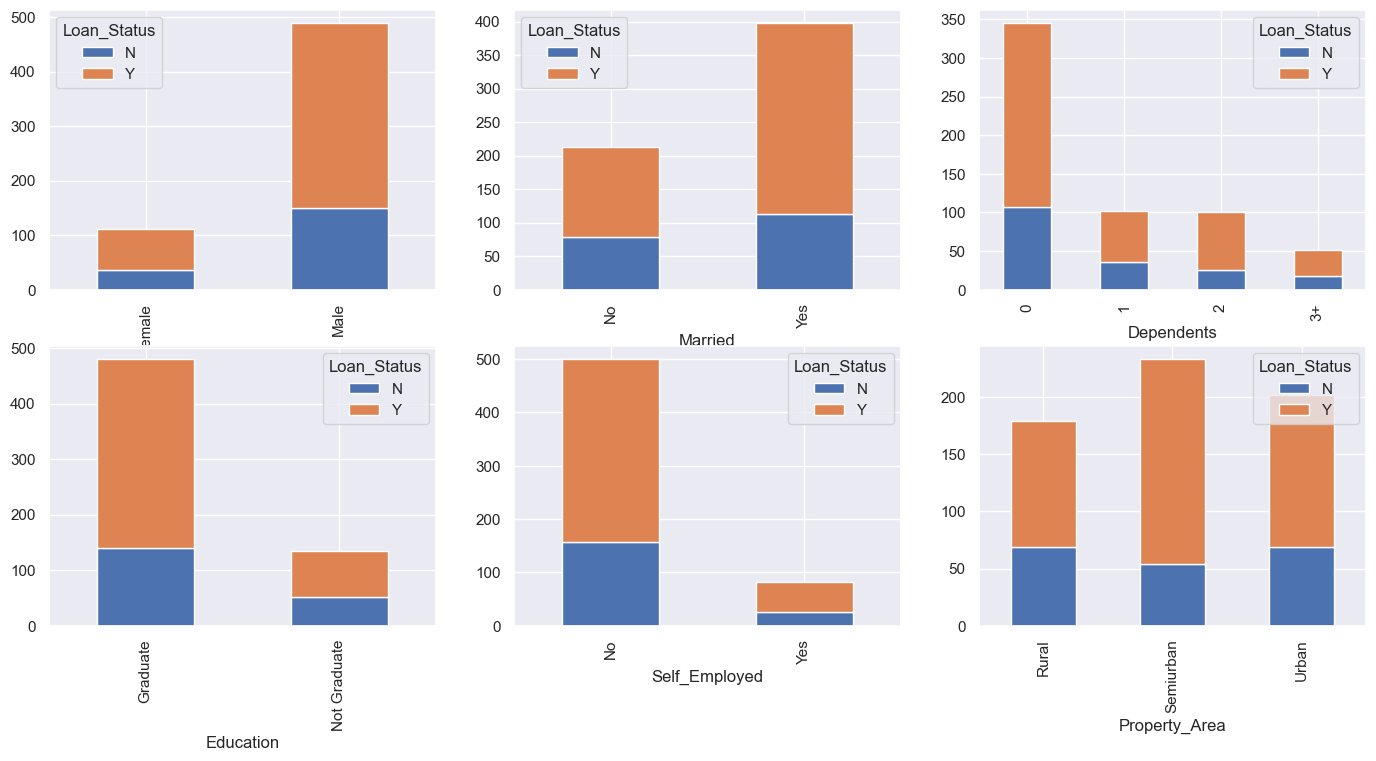

In [201]:
## Categorical  vs Target
fig, ax = plt.subplots(2,3, figsize=(17, 8))
pd.crosstab(loan["Gender"], loan["Loan_Status"]).plot(kind="bar", stacked=True, ax= ax[0,0])
pd.crosstab(loan["Married"], loan["Loan_Status"]).plot(kind="bar", stacked=True, ax= ax[0,1])
pd.crosstab(loan["Dependents"], loan["Loan_Status"]).plot(kind="bar", stacked=True, ax= ax[0,2])
pd.crosstab(loan["Education"], loan["Loan_Status"]).plot(kind="bar", stacked=True, ax= ax[1,0])
pd.crosstab(loan["Self_Employed"], loan["Loan_Status"]).plot(kind="bar", stacked=True, ax= ax[1,1])
pd.crosstab(loan["Property_Area"], loan["Loan_Status"]).plot(kind="bar", stacked=True, ax= ax[1,2])

C:\Users\EdwinVivekN\AppData\Local\Temp\ipykernel_27880\809911584.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(loan["Loan_Status"], palette='hls', stat='percent')


<Axes: xlabel='percent', ylabel='Loan_Status'>

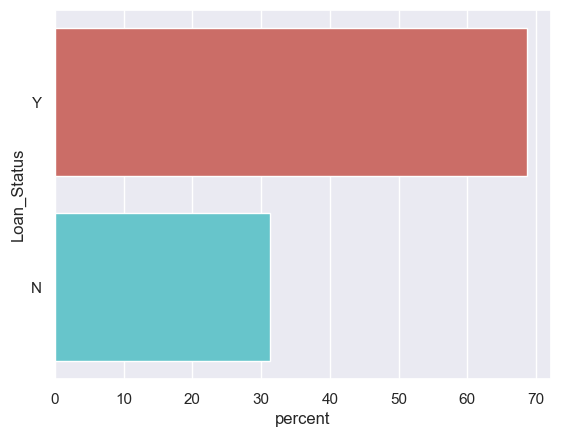

In [202]:
#check for imbalance class
sns.countplot(loan["Loan_Status"], palette='hls', stat='percent')

In [203]:
## Numerical Vs Target


In [204]:
combine_transforms = ColumnTransformer(transformers=[
    ("numeric_pipeline", numeric_pipeline, numeric_cols),
    ("cat_pipeline", cat_pipeline, cat_cols),
    ("binary_pipeline", binary_pipeline , bin_cols)
], remainder='passthrough')

final_pipeline = Pipeline(steps=[
    ("combine_transforms", combine_transforms)
])

final_pipeline

Pipeline(steps=[('combine_transforms',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log1p',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       validate=True))]),
                                                  ['ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('custom_imputer',
                                                                   Simpl...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  array(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Loan_Amount_Term', 'Property_Area'], dtype=object)),
                                                 ('binary_pipeline',
                                                  Pipeline(steps=[('binary_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Credit_History'])]))])

In [205]:
feature_names = numeric_cols.copy()
feature_names.extend(cat_transformed_columns)
feature_names.extend(bin_cols)
feature_names

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Gender_Male',
 'Married_Yes',
 'Dependents_1',
 'Dependents_2',
 'Dependents_3+',
 'Education_Not Graduate',
 'Self_Employed_Yes',
 'Loan_Amount_Term_Medium',
 'Loan_Amount_Term_Short',
 'Property_Area_Semiurban',
 'Property_Area_Urban',
 'Credit_History']

In [206]:
X = loan.loc[:, ~loan.columns.isin(["Loan_Status"])]
y = loan["Loan_Status"]
loan_X_train, loan_X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 20, stratify=y)

In [207]:
final_transforms = final_pipeline.fit_transform(loan_X_train)
X_train = pd.DataFrame(final_transforms, columns=feature_names, index=loan_X_train.index)
X_train

,ApplicantIncome,CoapplicantIncome,LoanAmount,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Loan_Amount_Term_Medium,Loan_Amount_Term_Short,Property_Area_Semiurban,Property_Area_Urban,Credit_History
104,8.247220,6.626718,5.081404,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
132,7.908019,0.000000,4.262680,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
247,8.796188,0.000000,4.927254,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
395,8.094684,6.184149,4.912655,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
506,9.944342,8.805075,6.175867,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,9.123365,0.000000,5.501258,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
533,9.328212,0.000000,5.283204,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
374,7.924796,7.286192,4.709530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
440,8.205492,8.530109,5.236442,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [208]:
final_x_valid = final_pipeline.fit_transform(loan_X_valid)
X_valid= pd.DataFrame(final_x_valid, columns=feature_names, index=loan_X_valid.index)
X_valid

,ApplicantIncome,CoapplicantIncome,LoanAmount,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Loan_Amount_Term_Medium,Loan_Amount_Term_Short,Property_Area_Semiurban,Property_Area_Urban,Credit_History
525,9.770013,0.000000,5.993961,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
451,7.580189,7.284135,4.110874,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
62,7.867106,8.146130,5.111988,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
78,8.060856,8.294300,5.198497,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
567,8.131825,7.824446,4.820282,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,5.017280,7.496097,4.912655,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
301,7.964156,7.467942,4.663439,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
592,9.143987,0.000000,5.680173,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
189,9.140883,0.000000,5.241747,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [209]:
X_train.isna().sum().sort_values(ascending=False)

ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                 0
Gender_Male                0
Married_Yes                0
Dependents_1               0
Dependents_2               0
Dependents_3+              0
Education_Not Graduate     0
Self_Employed_Yes          0
Loan_Amount_Term_Medium    0
Loan_Amount_Term_Short     0
Property_Area_Semiurban    0
Property_Area_Urban        0
Credit_History             0
dtype: int64

<Axes: xlabel='percent', ylabel='Loan_Status'>

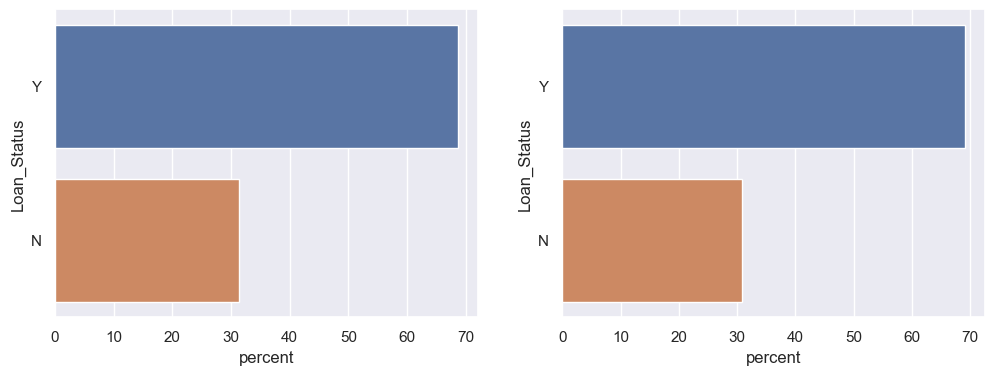

In [210]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.countplot(y=y_train, hue=y_train, legend=False, stat='percent', ax=ax[0])
sns.countplot(y=y_valid, hue=y_valid, legend=False, stat='percent', ax=ax[1], order=["Y", "N"], hue_order=["Y", "N"])

## Logistic regression Model 

In [214]:
logistic = make_pipeline(final_pipeline, LogisticRegression(solver='liblinear', multi_class='ovr',max_iter=500))

In [216]:
logistic.fit(loan_X_train, np.ravel(y_train))

C:\Users\EdwinVivekN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('combine_transforms',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('numeric_pipeline',
                                                                   Pipeline(steps=[('impute',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('log1p',
                                                                                    FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                        validate=True))]),
                                                                   ['ApplicantIncome',
                                                                    'CoapplicantIncome',
                                                                    'LoanAmount']),
                                                                  ('cat_pipeline',
                                                                   Pipeline(st...
                                                                                                  sparse_output=False))]),
                                                                   array(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Loan_Amount_Term', 'Property_Area'], dtype=object)),
                                                                  ('binary_pipeline',
                                                                   Pipeline(steps=[('binary_impute',
                                                                                    SimpleImputer(strategy='most_frequent'))]),
                                                                   ['Credit_History'])]))])),
                ('logisticregression',
                 LogisticRegression(max_iter=500, multi_class='ovr',
                                    solver='liblinear'))])

In [217]:
y_pred = logistic.predict(loan_X_valid)

In [218]:
model = logistic.steps[-1][1]
model

LogisticRegression(max_iter=500, multi_class='ovr', solver='liblinear')

In [219]:
coeff = pd.DataFrame(X_train.columns, columns=["Columns"])
coeff["Intercept"] = np.repeat(model.intercept_, coeff.shape[0])
coeff["Coefficients"] = pd.Series(model.coef_.ravel())
coeff['Odds ratio'] = pd.Series(np.exp(model.coef_.ravel()))  #exponent of coefficient is odds ratio
coeff

,Columns,Intercept,Coefficients,Odds ratio
0,ApplicantIncome,-0.493213,0.056151,1.057758
1,CoapplicantIncome,-0.493213,0.019680,1.019875
2,LoanAmount,-0.493213,-0.526302,0.590786
3,Gender_Male,-0.493213,-0.101176,0.903774
4,Married_Yes,-0.493213,0.560338,1.751264
5,Dependents_1,-0.493213,-0.607715,0.544594
6,Dependents_2,-0.493213,0.302106,1.352704
7,Dependents_3+,-0.493213,-0.059200,0.942518
8,Education_Not Graduate,-0.493213,-0.484575,0.615959
9,Self_Employed_Yes,-0.493213,0.040503,1.041334


In [220]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logistic, X, y, cv=5, scoring="accuracy")
print(f"Mean Accuracy: {scores.mean():.4f}")

C:\Users\EdwinVivekN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\EdwinVivekN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\EdwinVivekN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'm

Mean Accuracy: 0.8095


In [221]:
X_valid = final_pipeline.transform(loan_X_valid)  # transform test set using pipeline
print("Score:", model.score(X_valid, y_valid))
print("Actual iterations used:", model.n_iter_)

Score: 0.8048780487804879
Actual iterations used: [10]


In [222]:
y_pred_train = model.predict(X_train)
pred_proba_train = model.predict_proba(X_train)
pred_df_train = pd.DataFrame(pred_proba_train)
pred_df_train["Predictions"] = y_pred_train
pred_df_train["logit"] = np.log(pred_df_train[1]/ (1 - pred_df_train[1]))
pred_df_train

C:\Users\EdwinVivekN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\EdwinVivekN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


,0,1,Predictions,logit
0,0.198355,0.801645,Y,1.396609
1,0.138993,0.861007,Y,1.823677
2,0.429403,0.570597,Y,0.284288
3,0.077542,0.922458,Y,2.476224
4,0.277127,0.722873,Y,0.958757
...,...,...,...,...
486,0.369565,0.630435,Y,0.534084
487,0.318949,0.681051,Y,0.758604
488,0.244523,0.755477,Y,1.128040
489,0.183059,0.816941,Y,1.495762


In [119]:
y_pred = model.predict(X_valid)
pred_proba = model.predict_proba(X_valid)
pred_df = pd.DataFrame(pred_proba)
pred_df["Predictions"] = y_pred
pred_df

,0,1,Predictions
0,0.242647,0.757353,Y
1,0.154616,0.845384,Y
2,0.928779,0.071221,N
3,0.807394,0.192606,N
4,0.882837,0.117163,N
...,...,...,...
118,0.223504,0.776496,Y
119,0.137212,0.862788,Y
120,0.244465,0.755535,Y
121,0.239648,0.760352,Y


In [346]:
#Equivalent to the predict_proba method in sklearn
from scipy.special import expit
predict_proba_1 = expit(np.dot(X_train, model.coef_.ravel()) + model.intercept_)  #The expit function, also known as the logistic sigmoid function, is defined as expit(x) = 1/(1+exp(-x)). It is the inverse of the logit function.


#Equivalent to sklearn Logistic regression model
import statsmodels.api as sm
X_train_const = sm.add_constant(X_train)
y_train_mapped = y_train.map({'Y': 1, 'N': 0})  
logit_model= sm.Logit(y_train_mapped, X_train_const).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.441876
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            Loan_Status   No. Observations:                  491
Model:                          Logit   Df Residuals:                      475
Method:                           MLE   Df Model:                           15
Date:                Sun, 16 Mar 2025   Pseudo R-squ.:                  0.2896
Time:                        14:45:04   Log-Likelihood:                -216.96
converged:                       True   LL-Null:                       -305.40
Covariance Type:            nonrobust   LLR p-value:                 1.016e-29
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -2.7478      1.964     -1.399      0.162      -6.597   

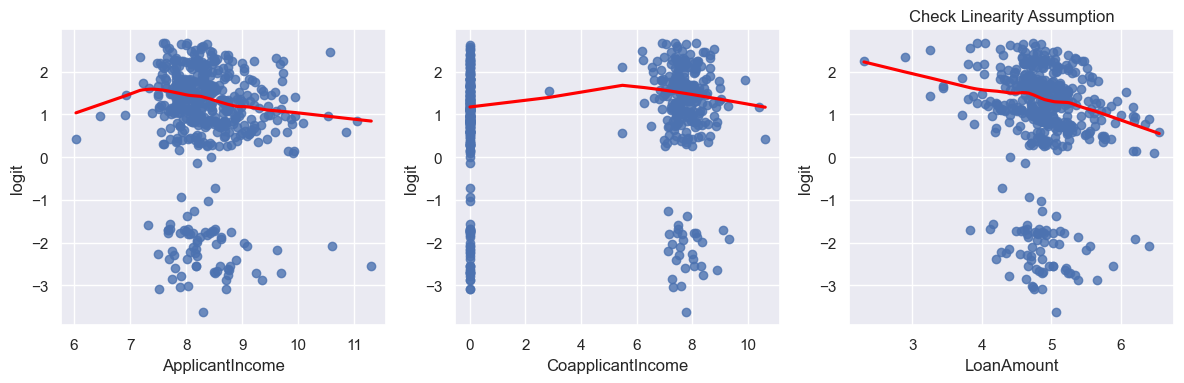

In [120]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
axes = axes.flat  
for i in range(3):
    ax = axes[i]
    #ax.plot([0, 1, 2], [i, i+1, i+2]) 
    sns.regplot(x=X_train.iloc[:,i], y=pred_df_train['logit'], lowess=True, line_kws={'color': 'red'}, ax =ax )
    #ax.set_title(f'Plot {i}')
    
plt.title("Check Linearity Assumption")
plt.tight_layout()

Text(0.5, 1.0, 'Confusion Matrix')

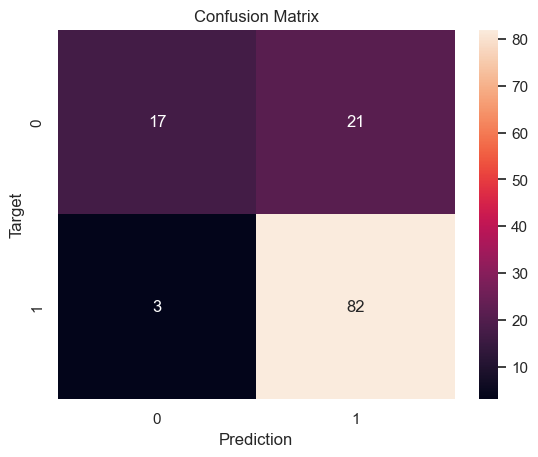

In [123]:
#Confusion matrix
cf = confusion_matrix(y_valid, y_pred, labels=["N","Y"])
tn, fp, fn, tp = cf.ravel()
#pd.crosstab(y_train, y_train_pred) 
plt.figure()
sns.heatmap(cf, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title('Confusion Matrix')

In [241]:
print(accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

0.8048780487804879
              precision    recall  f1-score   support

           N       0.85      0.45      0.59        38
           Y       0.80      0.96      0.87        85

    accuracy                           0.80       123
   macro avg       0.82      0.71      0.73       123
weighted avg       0.81      0.80      0.78       123



In [80]:
precision = precision_score(y_valid, y_pred, average=None)
print(precision)
recall = recall_score(y_valid, y_pred, average=None)
print(recall)

[0.85      0.7961165]
[0.44736842 0.96470588]


In [81]:
#Log loss

accuracy = log_loss(y_valid, pred_proba)
print("Logloss: %.2f" % (accuracy))

Logloss: 0.50


In [82]:
#kappa score

cohen_kappa_score(y_valid, y_pred)

0.47417171357320986

0.721671826625387
Best threshold: 0.5768299472238011


Text(0, 0.5, 'Sensitivity')

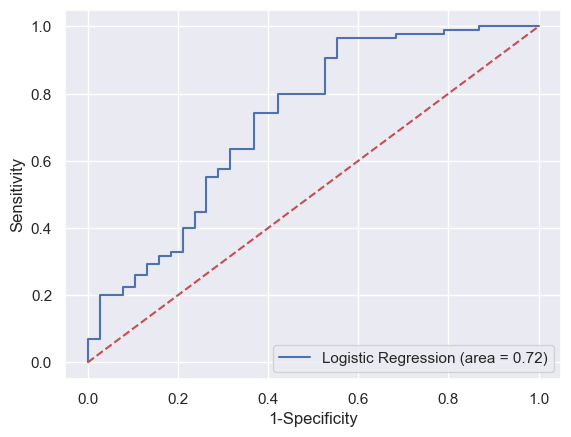

In [83]:
#ROC-AUC
logit_roc_auc = roc_auc_score(y_valid,  pred_proba[:,1])
print(logit_roc_auc)
fpr, tpr, thresholds = roc_curve(y_valid, pred_proba[:,1], pos_label="Y")

#Youden’s J statistic
youden_index = tpr - fpr  
best_threshold = thresholds[youden_index.argmax()] 
print(f"Best threshold: {best_threshold}")

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.legend(loc="lower right")
plt.xlabel("1-Specificity")
plt.ylabel("Sensitivity")

In [84]:
y_pred_final = (pred_df[1] >= best_threshold).astype(int)
y_pred_final = y_pred_final.map({1: "Y", 0: 'N'})  
# Evaluate the new predictions

print(classification_report(y_valid, y_pred_final))

              precision    recall  f1-score   support

           N       0.85      0.45      0.59        38
           Y       0.80      0.96      0.87        85

    accuracy                           0.80       123
   macro avg       0.82      0.71      0.73       123
weighted avg       0.81      0.80      0.78       123



Logistic: F1=0.872 PR AUC=0.831
Best PR threshold: 0.5768299472238011
Average precision-recall score: 0.83


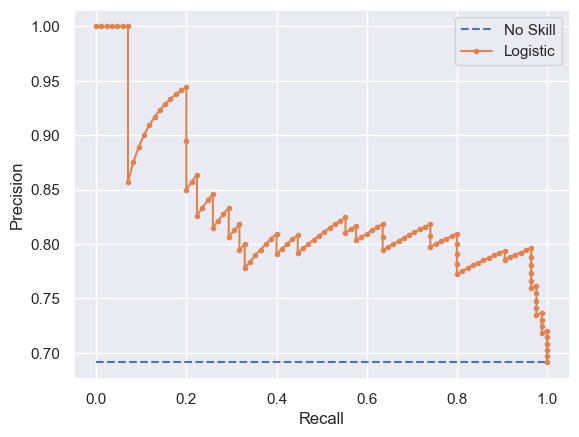

In [85]:
#PR curve
lr_precision, lr_recall, lr_thresholds = precision_recall_curve(y_valid, pred_proba[:,1], pos_label="Y")
lr_f1= f1_score(y_valid, y_pred, pos_label="Y")
lr_auc = auc(lr_recall, lr_precision)
print('Logistic: F1=%.3f PR AUC=%.3f' % (lr_f1, lr_auc))

f1_scores = (2 * lr_precision * lr_recall) / (lr_precision + lr_recall)
best_pr_threshold = lr_thresholds[f1_scores.argmax()]
print(f"Best PR threshold: {best_pr_threshold}")

no_skill = len(y_valid[y_valid == 'Y']) / len(y_valid)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

avg_precision = average_precision_score(y_valid, pred_proba[:,1], pos_label="Y")
print('Average precision-recall score: {0:0.2f}'.format(
      avg_precision))

In [86]:
#Gain and lift
skplot.metrics.plot_cumulative_gain(y_valid, pred_proba)
skplot.metrics.plot_lift_curve(y_valid, pred_proba)
plt.legend(loc='best')

NameError: name 'skplot' is not defined

In [87]:
# Calculate gains
y_valid_mapped = y_valid.map({'Y': 1, 'N': 0})  
df = pd.DataFrame({'true': y_valid_mapped, 'pred': pred_proba[:,1]})
df = df.sort_values('pred', ascending=False)
df['cumulative'] = np.cumsum(df['true']) / df['true'].sum()
df['percentage'] = np.arange(start=1, stop=len(df) + 1) / len(df)
df['lift'] = df['cumulative'] / df['percentage']   #lift
df

,true,pred,cumulative,percentage,lift
582,1,0.944631,0.011765,0.00813,1.447059
335,1,0.932744,0.023529,0.01626,1.447059
555,1,0.921360,0.035294,0.02439,1.447059
281,1,0.908185,0.047059,0.03252,1.447059
111,1,0.907600,0.058824,0.04065,1.447059
...,...,...,...,...,...
128,0,0.074543,1.000000,0.96748,1.033613
62,0,0.071221,1.000000,0.97561,1.025000
584,0,0.064524,1.000000,0.98374,1.016529
66,0,0.049780,1.000000,0.99187,1.008197


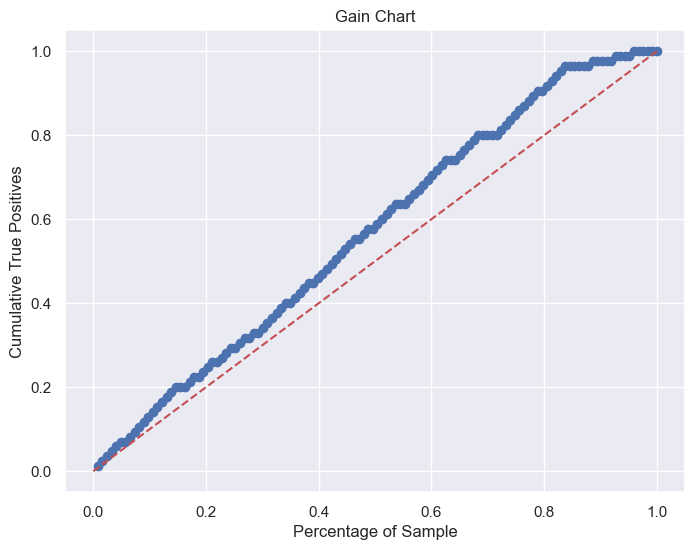

In [88]:
# Plotting the gain chart
plt.figure(figsize=(8, 6))
plt.plot(df['percentage'], df['cumulative'], marker='o', linestyle='-', color='b')
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.title('Gain Chart')
plt.xlabel('Percentage of Sample')
plt.ylabel('Cumulative True Positives')
plt.show()

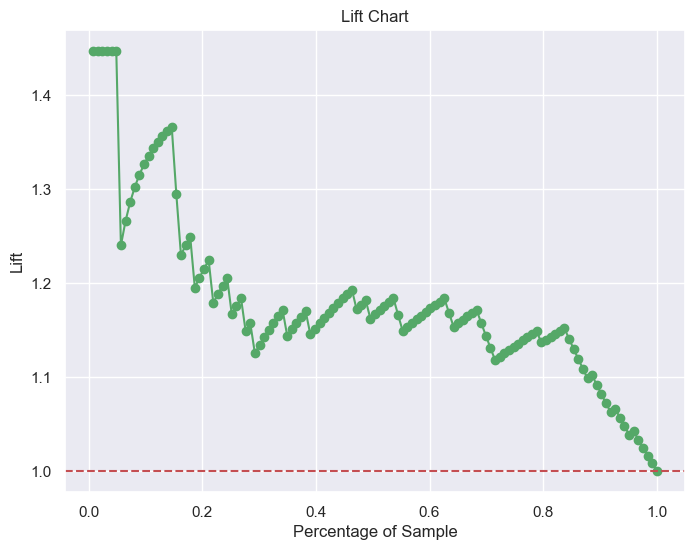

In [89]:
# Plotting the lift chart
plt.figure(figsize=(8, 6))
plt.plot(df['percentage'], df['lift'], marker='o', linestyle='-', color='g')
plt.axhline(y=1, color='r', linestyle='--')
plt.title('Lift Chart')
plt.xlabel('Percentage of Sample')
plt.ylabel('Lift')
plt.show()

## Decision Trees

In [224]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='gini')
tree_pipe = make_pipeline(final_pipeline, tree)

In [225]:
tree_pipe.fit(loan_X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('combine_transforms',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('numeric_pipeline',
                                                                   Pipeline(steps=[('impute',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('log1p',
                                                                                    FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                        validate=True))]),
                                                                   ['ApplicantIncome',
                                                                    'CoapplicantIncome',
                                                                    'LoanAmount']),
                                                                  ('cat_pipeline',
                                                                   Pipeline(st...
                                                                                    OneHotEncoder(drop='first',
                                                                                                  handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   array(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Loan_Amount_Term', 'Property_Area'], dtype=object)),
                                                                  ('binary_pipeline',
                                                                   Pipeline(steps=[('binary_impute',
                                                                                    SimpleImputer(strategy='most_frequent'))]),
                                                                   ['Credit_History'])]))])),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

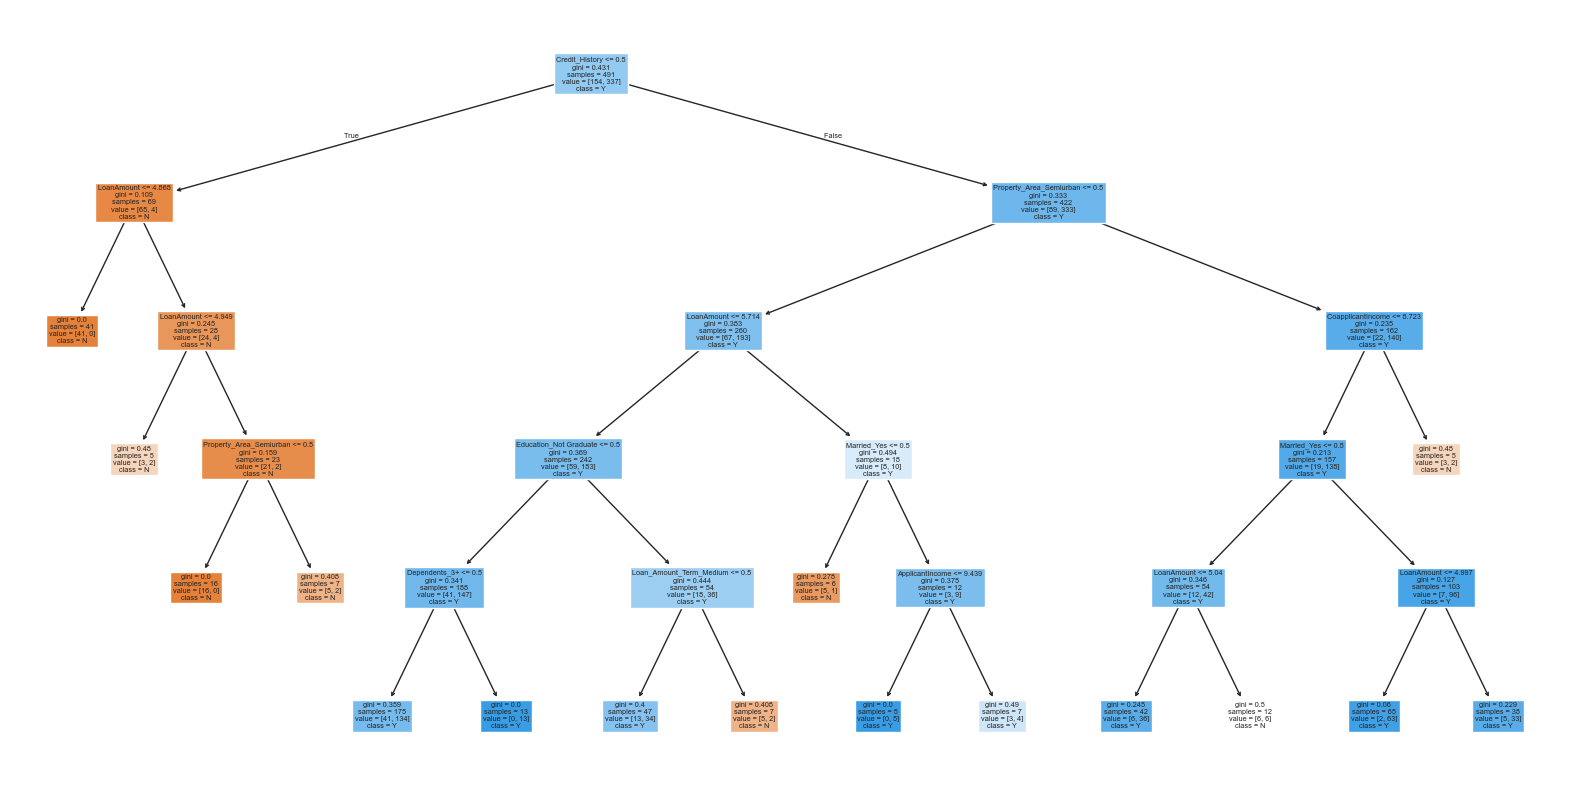

In [271]:
from sklearn.tree import plot_tree
tree_model = tree_pipe_tuned.named_steps["decisiontreeclassifier"]

plt.figure(figsize=(20,10))  # Adjust the figure size as needed
plot_tree(tree_model, filled=True, feature_names=X_train.columns.tolist(), 
  class_names=tree_model.classes_.tolist())
plt.show()


In [239]:
y_pred_tree = tree_pipe.predict(loan_X_valid)

In [232]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_pipe, X, y, cv=5, scoring="accuracy")
print(f"Mean Accuracy: {scores.mean():.4f}")

Mean Accuracy: 0.7003


In [240]:
accuracy_score(y_valid, y_pred_tree)

0.6829268292682927

In [246]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'decisiontreeclassifier__max_depth': [3, 5, 10, None],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 5]
}

grid_search = GridSearchCV(tree_pipe, param_grid, cv=5)
grid_search.fit(loan_X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__min_samples_leaf': 5, 'decisiontreeclassifier__min_samples_split': 10}


In [262]:
tree_tuned = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=5, min_samples_split=10)
tree_pipe_tuned = make_pipeline(final_pipeline, tree_tuned)
tree_pipe_tuned.fit(loan_X_train, y_train)
y_pred_tree_tuned = tree_pipe_tuned.predict(loan_X_valid)
accuracy_score(y_valid, y_pred_tree_tuned)

0.7642276422764228

## Random Forest

In [313]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=500, random_state=1, oob_score=True)
rf_pipe = make_pipeline(final_pipeline, random_forest)
rf_pipe.fit(loan_X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('combine_transforms',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('numeric_pipeline',
                                                                   Pipeline(steps=[('impute',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('log1p',
                                                                                    FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                        validate=True))]),
                                                                   ['ApplicantIncome',
                                                                    'CoapplicantIncome',
                                                                    'LoanAmount']),
                                                                  ('cat_pipeline',
                                                                   Pipeline(st...
                                                                                                  sparse_output=False))]),
                                                                   array(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Loan_Amount_Term', 'Property_Area'], dtype=object)),
                                                                  ('binary_pipeline',
                                                                   Pipeline(steps=[('binary_impute',
                                                                                    SimpleImputer(strategy='most_frequent'))]),
                                                                   ['Credit_History'])]))])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=500, oob_score=True,
                                        random_state=1))])

In [364]:
rf_pipe.score(loan_X_train, y_train)

1.0

In [299]:
y_pred_rf = rf_pipe.predict(loan_X_valid)
accuracy_score(y_valid, y_pred_rf)

0.8130081300813008

In [309]:
rf_pipe.named_steps["randomforestclassifier"].oob_score_

0.7820773930753564

In [294]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_pipe2 = make_pipeline(final_pipeline, rf)
params = {
    'randomforestclassifier__max_depth': [2,3,5,10,20],
    'randomforestclassifier__min_samples_leaf': [5,10,20,50,100,200],
    'randomforestclassifier__n_estimators': [10,25,30,50,100,200]
}

grid_search = GridSearchCV(estimator=rf_pipe2,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(loan_X_train, y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('combine_transforms',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('numeric_pipeline',
                                                                                          Pipeline(steps=[('impute',
                                                                                                           SimpleImputer(strategy='median')),
                                                                                                          ('log1p',
                                                                                                           FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                                               validate=True))]),
                                                                                          ['ApplicantIncome',
                                                                                           'CoapplicantIncome',
                                                                                           'LoanAmount'])...
                                                                                                           SimpleImputer(strategy='most_frequent'))]),
                                                                                          ['Credit_History'])]))])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [2, 3, 5, 10, 20],
                         'randomforestclassifier__min_samples_leaf': [5, 10, 20,
                                                                      50, 100,
                                                                      200],
                         'randomforestclassifier__n_estimators': [10, 25, 30,
                                                                  50, 100,
                                                                  200]},
             scoring='accuracy', verbose=1)

In [296]:
print(grid_search.best_score_)

rf_best = grid_search.best_estimator_
print(rf_best)

0.812624950019992
Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('combine_transforms',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('numeric_pipeline',
                                                                   Pipeline(steps=[('impute',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('log1p',
                                                                                    FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                        validate=True))]),
                                                                   ['ApplicantIncome',
                                                                    'CoapplicantIncome',
  

<Axes: xlabel='Imp', ylabel='Varname'>

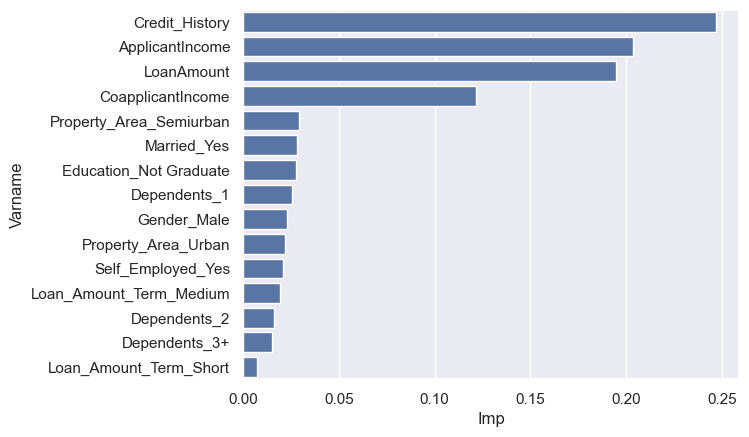

In [304]:
#Feature importance
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": random_forest.feature_importances_
})
sorted_imp = imp_df.sort_values('Imp', ascending=False)
sns.barplot(y=sorted_imp["Varname"], x=sorted_imp["Imp"])

In [358]:
from sklearn.feature_selection import RFECV
rf_model = RandomForestClassifier(n_estimators=rf_best[1].n_estimators, 
                                 max_depth=rf_best[1].max_depth, 
                                 min_samples_leaf= rf_best[1].min_samples_leaf,
                                 random_state=42)
rfe = RFECV(rf_model,cv=5,scoring="neg_mean_squared_error")
rfe_rf_pipe = Pipeline([
    ("preprocessing", final_pipeline),
    ("rfe", rfe),
    ("random_forest", rf_model)
])
rfe_rf_pipe.fit(loan_X_train,y_train_mapped)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('combine_transforms',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('numeric_pipeline',
                                                                   Pipeline(steps=[('impute',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('log1p',
                                                                                    FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                        validate=True))]),
                                                                   ['ApplicantIncome',
                                                                    'CoapplicantIncome',
                                                                    'LoanAmount']),
                                                                  ('cat_pipeline',
                                                                   Pipeli...
       'Loan_Amount_Term', 'Property_Area'], dtype=object)),
                                                                  ('binary_pipeline',
                                                                   Pipeline(steps=[('binary_impute',
                                                                                    SimpleImputer(strategy='most_frequent'))]),
                                                                   ['Credit_History'])]))])),
                ('rfe',
                 RFECV(cv=5,
                       estimator=RandomForestClassifier(max_depth=10,
                                                        min_samples_leaf=5,
                                                        random_state=42),
                       scoring='neg_mean_squared_error')),
                ('random_forest',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=5,
                                        random_state=42))])

In [359]:
selected_features = X_train.columns[rfe.support_]
feature_ranking = dict(zip(X_train.columns, rfe.ranking_))

print("Selected Features:", list(selected_features))
print("Feature Ranking:", feature_ranking)

Selected Features: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Gender_Male', 'Married_Yes', 'Dependents_1', 'Education_Not Graduate', 'Property_Area_Semiurban', 'Property_Area_Urban', 'Credit_History']
Feature Ranking: {'ApplicantIncome': 1, 'CoapplicantIncome': 1, 'LoanAmount': 1, 'Gender_Male': 1, 'Married_Yes': 1, 'Dependents_1': 1, 'Dependents_2': 2, 'Dependents_3+': 4, 'Education_Not Graduate': 1, 'Self_Employed_Yes': 5, 'Loan_Amount_Term_Medium': 3, 'Loan_Amount_Term_Short': 6, 'Property_Area_Semiurban': 1, 'Property_Area_Urban': 1, 'Credit_History': 1}


In [390]:
y_valid_mapped = y_valid.map({'Y': 1, 'N': 0})  
y_pred_rfe_rf = rfe_rf_pipe.predict(loan_X_valid)
print(rfe_rf_pipe.score(loan_X_valid, y_valid_mapped))
accuracy_score(y_valid_mapped, y_pred_rfe_rf)


0.8048780487804879


0.8048780487804879

C:\Users\EdwinVivekN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\EdwinVivekN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\EdwinVivekN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\EdwinVivekN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra

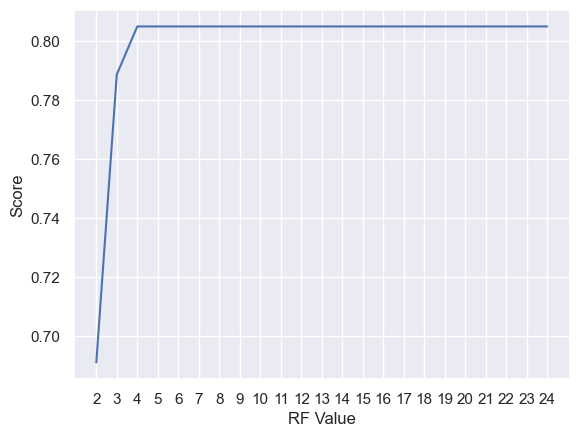

Random Forest Accuracy:  80.49%


In [272]:
scoreListRF = []
for i in range(2,25):
    RFclassifier = RandomForestClassifier(n_estimators = 1000, random_state = 1, max_leaf_nodes=i)
    RFclassifier.fit(X_train, y_train)
    scoreListRF.append(RFclassifier.score(X_valid, y_valid))
    
plt.plot(range(2,25), scoreListRF)
plt.xticks(np.arange(2,25,1))
plt.xlabel("RF Value")
plt.ylabel("Score")
plt.show()
RFAcc = max(scoreListRF)
print("Random Forest Accuracy:  {:.2f}%".format(RFAcc*100))

## Test data validation


In [61]:
loan_test = pd.read_csv(os.path.abspath(os.path.join(os.getcwd(), 'data\\test_loanpred.csv')))
loan_test.shape

(367, 12)

In [26]:
loan_test.isna().sum().sort_values(ascending=False)

Credit_History       29
Self_Employed        23
Gender               11
Dependents           10
Loan_Amount_Term      6
LoanAmount            5
Loan_ID               0
Married               0
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
dtype: int64

In [62]:
loan_test.drop(columns=['Loan_ID'], axis=1, inplace=True)
loan_test["Loan_Amount_Term"] = loan_test["Loan_Amount_Term"].astype('category')

In [ ]:
numeric_test_transformed = numeric_transforms.transform(loan_test[numeric_cols])
numeric_test_transformed_df = pd.DataFrame(numeric_test_transformed, columns=numeric_cols, index=loan_test.index)

cat_test_transformed = cat_encode.transform(loan_test[cat_cols])
cat_test_transformed_df = pd.DataFrame(cat_test_transformed, columns=cat_encode.named_steps["one_hot"].get_feature_names_out(), index=loan_test.index)

binary_test_transformed = binary_impute.transform(loan_test)
binary_test_transformed_df = pd.DataFrame(binary_test_transformed, columns=binary_impute.get_feature_names_out())

loan_test_final = loan_test.drop(columns=drop_cols).join(numeric_test_transformed_df).join(cat_test_transformed_df).join(binary_test_transformed_df)
loan_test_final

In [177]:
loan_test_transforms = final_pipeline.transform(loan_test)
X_test = pd.DataFrame(loan_test_transforms, columns=feature_names, index=loan_test.index)
X_test.isna().sum()

ApplicantIncome            0
CoapplicantIncome          0
LoanAmount                 0
Gender_Male                0
Married_Yes                0
Dependents_1               0
Dependents_2               0
Dependents_3+              0
Education_Not Graduate     0
Self_Employed_Yes          0
Loan_Amount_Term_Medium    0
Loan_Amount_Term_Short     0
Property_Area_Semiurban    0
Property_Area_Urban        0
Credit_History             0
dtype: int64

In [178]:
logistic.predict(loan_test)

array(['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y',
       'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'N', 'Y',
       'Y', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'N', 'Y', 'N', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y',
       'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y',
       'N', 'N', 'N', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'N', 'Y', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'N',
       'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y',
       'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'N',
       'Y', 'Y', 'Y', 'Y', 'N', 'N', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y

In [ ]:
#Recursive Feature Elimination
from sklearn.feature_selection import RFE
rfe = RFE(reg, n_features_to_select=5, step=1)
rfe = rfe.fit(x_train, y_train.values.ravel())
rfe_df = pd.DataFrame(x_train.columns)
rfe_df ["Support"] = pd.Series(rfe.support_)
rfe_df ["Ranking"] =  pd.Series(rfe.ranking_)
rfe_df
#remove features
#x_train = x_train[rfe_df[rfe_df['Support'] ==True][0]] 

In [ ]:
#chi square test for feature independence
from sklearn.feature_selection import chi2
chi_scores  = chi2(x_train, y_train)
chi_table = pd.DataFrame(x_train.columns)
chi_table['Chi Score'] = chi_scores[0]
chi_table['p-value'] = chi_scores[1]
print(chi_table)
p_values = pd.Series(chi_scores[1], index = x_train.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()

## Test cases

In [276]:
from deepchecks.tabular import Dataset
ds = Dataset(loan, cat_features=cat_cols, label='Loan_Status')
ds

,Column,DType,Kind,Additional Info
0,Loan_Status,string,,
1,Gender,string,Categorical Feature,
2,Married,string,Categorical Feature,
3,Dependents,string,Categorical Feature,
4,Education,string,Categorical Feature,
5,Self_Employed,string,Categorical Feature,
6,ApplicantIncome,integer,Numerical Feature,
7,CoapplicantIncome,integer,Numerical Feature,
8,LoanAmount,floating,Numerical Feature,
9,Loan_Amount_Term,categorical,Categorical Feature,


In [278]:
from deepchecks.tabular.suites import data_integrity
integrity = data_integrity()
integrity_res = integrity.run(ds)
integrity_res.show()


C:\Users\EdwinVivekN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\function_base.py:520: RuntimeWarning:

Mean of empty slice.

C:\Users\EdwinVivekN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\EdwinVivekN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\deepchecks\tabular\checks\data_integrity\feature_feature_correlation.py:111: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Accordion(children=(VBox(children=(HTML(value='\n<h1 id="summary_7RI0WU80ZL2B7888VAJT8DOEU">Data Integrity Sui…

In [294]:
from deepchecks.tabular.suites import train_test_validation
train_ds = ds = Dataset(X_train, cat_features=[], label=y_train)
test_ds = Dataset(X_valid, cat_features=[], label=y_valid)
validation_suite = train_test_validation()
validation_res = validation_suite.run(train_ds, test_ds)
validation_res.show()

C:\Users\EdwinVivekN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\deepchecks\tabular\checks\train_test_validation\train_test_samples_mix.py:85: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Accordion(children=(VBox(children=(HTML(value='\n<h1 id="summary_WW5DUJUCLBNZWATM2E1JCCJ9Y">Train Test Validat…